In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import GPyOpt
from torch.autograd import Variable

In [3]:
def normalize(data, norm_type):
    if norm_type == "minmax":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].min()) / (data[:,i].max()-data[:,i].min())
        return data
    elif norm_type == "zscore":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].mean()) / (data[:,i].std())
        return data
    elif norm_type == None:
        return data
    else:
        raise ValueError("Please choose a correct normalization type")
#Xnumtrain = torch.tensor(np.vstack([(Xnumtrain[:,i]-Xnumtrain[:,i].min()) / (Xnumtrain[:,i].max()-Xnumtrain[:,i].min()) for i in range(Xnumtrain.size()[1]) if "Tue elsker det her"])).view(-1,2)

def dataprep(data, norm_type = "zscore"):
    for category in categoricals:
        data[category] = data[category].astype("category")

    catdata = []
    for i in range(len(categoricals)):
        catdata.append(data[categoricals[i]].cat.codes.values)
    catdata = torch.tensor(catdata, dtype = torch.int64).T
    
    
    numdata = np.stack([data[col].values for col in numericals], 1)
    numdata = torch.tensor(numdata, dtype=torch.float)

    normalize(numdata, norm_type)
    return catdata, numdata

def permutation(data, cat):
    perm_data = data.copy()
    rand_num = np.random.randint(0 , len(data[cat]) , len(data[cat]))
    perm_data[cat][np.arange(len(data[cat]))] = data[cat][rand_num] 
    df = perm_data
    return df

def reset_data():
    return pd.read_csv("https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv")

# Data Visualization and Pre-processing

In [4]:
url = "https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv"
data = pd.read_csv(url)

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
#print(data.columns)

No GPU available.


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


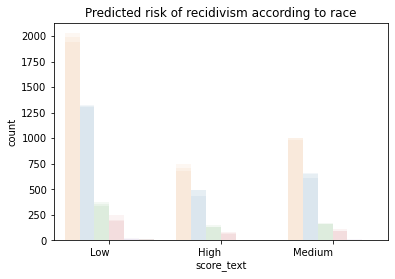

In [6]:
def is_plot():
    
    path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"
    
    pred_plot_race = sb.countplot(x = "score_text", hue = "race", data = data)
    pred_plot_race.set_title("Predicted risk of recidivism according to race")
    #pred_plot_race.figure.savefig(path + "\\predicted_recid_race.png")
    plt.show()
    
    pred_plot_sex = sb.countplot(x = "score_text", hue = "sex", data = data)
    pred_plot_sex.set_title("Predicted risk of recidivism according to sex")
    #pred_plot_sex.figure.savefig(path + "\\predicted_recid_sex.png")
    plt.show()
    
    true_plot = sb.countplot(x = "is_recid", hue = "race", data = data)
    true_plot.set_title("True recidivism scores")
    #true_plot.figure.savefig(path + "\\true_recid.png")
    plt.show()
    
    df = data[(data["race"] == "African-American") | (data["race"] == "Caucasian")]
    df = df[df["priors_count"] < 25]
    
    priors_plot = sb.countplot(x = "priors_count", hue = "race", data = df)
    priors_plot.set_title("Number of previous felonies according to race")
    #priors_plot.figure.savefig(path + "\\proirs.png")
    plt.show()
    
    c_charge_degree = sb.countplot(x = "c_charge_degree", hue = "race", data = df)
    c_charge_degree.set_title("Severity of the crimes for each race")
    #c_charge_degree.figure.savefig(path + "\\c_charge_degree.png")
    plt.show()
    
    c_charge_degree = sb.countplot(x = "score_text", hue = "c_charge_degree", data = df)
    c_charge_degree.set_title("Relation between crime severity and predicted recidivism")
    #c_charge_degree.figure.savefig(path + "\\charge_degree_score.png")
    plt.show()
    
    
#is_plot()

palette = {"Caucasian": "C0", "African-American": "C1", "Hispanic": "C2", "Other": "C3" , "Asian": "C4" ,"Native American": "C5"}
for i in tqdm(range(3)):
    #TODO: der skal indsættes punkter for den rigtige data1fordelling. 
    data = permutation(data, "race")
    path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"
    pred_plot_race = sb.countplot(x = "score_text" ,hue = "race", data = data, palette = palette ,alpha=.06,  hue_order = [ "African-American","Caucasian", "Hispanic", "Other" , "Asian","Native American"])
    pred_plot_race.set_title("Predicted risk of recidivism according to race")
    pred_plot_race.set_xticklabels(pred_plot_race.get_xticklabels(), horizontalalignment ='right')
    pred_plot_race.get_legend().remove()
    data = reset_data()

    


In [7]:
categoricals = ["c_charge_degree", "race", "age_cat", "sex"] # "r_charge_degree"    "two_year_recid"    "is_recid", "is_violent_recid"
numericals = ["age", "priors_count", "juv_fel_count", "juv_misd_count"] # "days_b_screening_arrest"
outputs = ["score_text"]
data = data[categoricals + numericals + outputs + ["two_year_recid"] + ["is_recid"]]

# Making the output binary
data[outputs] = data[outputs].replace('Low',0)
data[outputs] = data[outputs].replace('Medium',1)
data[outputs] = data[outputs].replace('High',1)
data[outputs] = data[outputs].astype("category")

In [8]:
Xcat, Xnum = dataprep(data, norm_type = "zscore")

# Converting the output to tensor
y = torch.tensor(data[outputs].values).flatten()

# Calculation of embedding sizes for the categorical values in the format (unique categorical values, embedding size (dimension of encoding))
categorical_column_sizes = [len(data[column].cat.categories) for column in categoricals]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

# Train-test split
totalnumber = len(Xnum)
testnumber = int(totalnumber * 0.2)

Xcattrain = Xcat[:totalnumber - testnumber]
Xcattest = Xcat[totalnumber - testnumber:totalnumber]
Xnumtrain = Xnum[:totalnumber - testnumber]
Xnumtest = Xnum[totalnumber - testnumber:totalnumber]
ytrain = y[:totalnumber - testnumber]
ytest = data["is_recid"][totalnumber - testnumber:totalnumber]
ytest = torch.tensor(ytest.values).flatten()


# Make sure that we dont validate on training data to compare if the algorithm is biased


normalize(Xnumtrain, "zscore");
normalize(Xnumtest, "zscore");

# Neural Network

In [9]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return nn.functional.sigmoid(x)

# Train the Model (The currently used model)

In [10]:
# Define and show the model
model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)
for param in model.parameters():
            param.requires_grad = True


Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(6, 3)
    (2): Embedding(3, 2)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64

In [11]:
# Loss function and optimization
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
threshold = 0.5
epochs = 1000
np.random.seed(42)

epoch:   1 loss: 0.76622266
epoch:  26 loss: 0.67802334
epoch:  51 loss: 0.62657309
epoch:  76 loss: 0.59195006
epoch: 101 loss: 0.57521576
epoch: 126 loss: 0.56154418
epoch: 151 loss: 0.54873788
epoch: 176 loss: 0.54985356
epoch: 201 loss: 0.54084635
epoch: 226 loss: 0.53650820
epoch: 251 loss: 0.53703690
epoch: 276 loss: 0.53014487
epoch: 301 loss: 0.52332485
epoch: 326 loss: 0.52997452
epoch: 351 loss: 0.53003532
epoch: 376 loss: 0.52021134
epoch: 401 loss: 0.51879644
epoch: 426 loss: 0.52141243
epoch: 451 loss: 0.52012450
epoch: 476 loss: 0.52031100
epoch: 501 loss: 0.52579236
epoch: 526 loss: 0.51264089
epoch: 551 loss: 0.51268888
epoch: 576 loss: 0.51695180
epoch: 601 loss: 0.51555192
epoch: 626 loss: 0.51683700
epoch: 651 loss: 0.51174915
epoch: 676 loss: 0.51533538
epoch: 701 loss: 0.51309276
epoch: 726 loss: 0.51311922
epoch: 751 loss: 0.51068616
epoch: 776 loss: 0.51433909
epoch: 801 loss: 0.51104891
epoch: 826 loss: 0.51067364
epoch: 851 loss: 0.51124388
epoch: 876 loss: 0.5

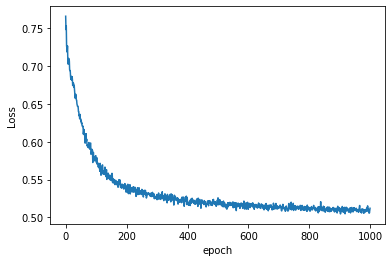

In [10]:
aggregated_losses = []

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

model.train()
for i in range(epochs):
    i += 1
    y_pred = model(Xcattrain, Xnumtrain)
    single_loss = loss_function(y_pred, ytrain.float())
    aggregated_losses.append(single_loss)

    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')



# Plot the loss over epocs
if "plot":
    plt.plot(range(epochs), aggregated_losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch');


# Predict on the test set
model.eval()
with torch.no_grad():
    y_val = model(Xcattest, Xnumtest)
    loss = loss_function(y_val, ytest.float())


y_pred = (y_val > threshold).float()


print(confusion_matrix(ytest,y_pred))
print(classification_report(ytest,y_pred))
print(accuracy_score(ytest, y_pred))

# Confusion matrix for black/white

In [13]:
df = data[totalnumber - testnumber:totalnumber]
black_data = df[df["race"]=="African-American"]
white_data = df[df["race"]=="Caucasian"]
Xcat_white, Xnum_white = dataprep(white_data, norm_type = "zscore")
Xcat_black, Xnum_black = dataprep(black_data, norm_type = "zscore")
model.eval()
y_val_white = model(Xcat_white, Xnum_white)
y_pred1 = (y_val_white > threshold).float()
y_val_black = model(Xcat_black, Xnum_black)
y_pred2 = (y_val_black > threshold).float()

# Ground truth of recidivism from dataset
y_white = torch.tensor(white_data["is_recid"].values).flatten()
y_black = torch.tensor(black_data["is_recid"].values).flatten()

print("Confussion matrix for the white:")
conf_white = confusion_matrix( y_white, y_pred1)
print(conf_white)
print(conf_white / conf_white.astype(np.float).sum())
print()
print("Confussion matrix for the black:")
conf_black = confusion_matrix( y_black, y_pred2)
print(conf_black)
print(conf_black / conf_black.astype(np.float).sum())

Confussion matrix for the white:
[[202  81]
 [ 69 123]]
[[0.71378092 0.421875  ]
 [0.24381625 0.640625  ]]

Confussion matrix for the black:
[[251  74]
 [195 224]]
[[0.77230769 0.17661098]
 [0.6        0.53460621]]


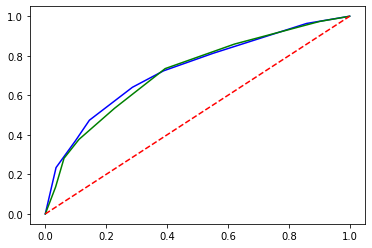

In [20]:
points = 8
thresholds = np.arange(0,1,1/points)
thresholds = np.append(thresholds,999)
tprs1 = []
fprs1 = []
tprs2 = []
fprs2 = []
for i in range(points+1):
    y_pred1 = (y_val_white > thresholds[i]).float()
    y_pred2 = (y_val_black > thresholds[i]).float()
    
    conf1,conf2 = confusion_matrix( y_white, y_pred1), confusion_matrix( y_black,  y_pred2)
    
    tprs1.append(conf1[1,1] / (conf1[1,1] + conf1[1,0]))
    fprs1.append(conf1[0,1] / (conf1[0,1] + conf1[0,0]))
    tprs2.append(conf2[1,1] / (conf2[1,1] + conf2[1,0]))
    fprs2.append(conf2[0,1] / (conf2[0,1] + conf2[0,0]))
    
plt.plot(fprs1,tprs1,color="blue")
plt.plot(fprs2,tprs2,color="green")
point1 = [0,0]
point2 = [1,1]
x_values = [point1[0], point2[0]] 
y_values = [point1[1], point2[1]]
roc = plt.plot(x_values, y_values,'--',color="red")
plt.show()
#roc.figure.savefig(path + "\\ROC.png")


    

[0.         0.28621908 1.        ] [0.       0.640625 1.      ]


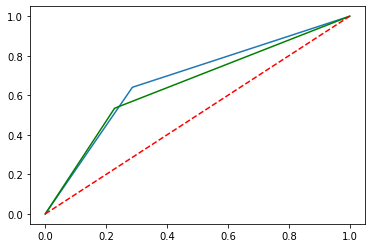

In [15]:
from sklearn import metrics
y_pred1 = (y_val_white > 0.5).float()
y_pred2 = (y_val_black > 0.5).float()
fpr, tpr, thresholds = metrics.roc_curve(y_white, y_pred1.view(-1),pos_label=1)
fpr2, tpr2, thresholds = metrics.roc_curve(y_black, y_pred2.view(-1),pos_label=1)
print(fpr,tpr)
plt.plot(fpr,tpr)
plt.plot(fpr2,tpr2,color="green")
plt. plot(x_values, y_values,'--',color="red")
plt.show()

* # Fede plots til fremtiden måske:


# Plots of the distribution of black and whites in each category of scoretext
sb.countplot(x = "score_text", data = black_data)
print(len(black_data[black_data["score_text"] == 0]))
print(len(black_data[black_data["score_text"] == 1]))
plt.show()
sb.countplot(x = "score_text", data = white_data)
print(len(white_data[white_data["score_text"] == 0]))
print(len(white_data[white_data["score_text"] == 1]))
plt.show()